 # Exploring FIFA World Cup 2022 Data
 - [Description](#Description)
 - [Loading Data](#Loading-Data)
 - [EDA](#EDA)
 - [World Cup 2022](#World-Cup-2022)
 - [Modeling](#Modeling)
 - [Prediction](#Prediction)
 - [Summary](#Summary)

# Description

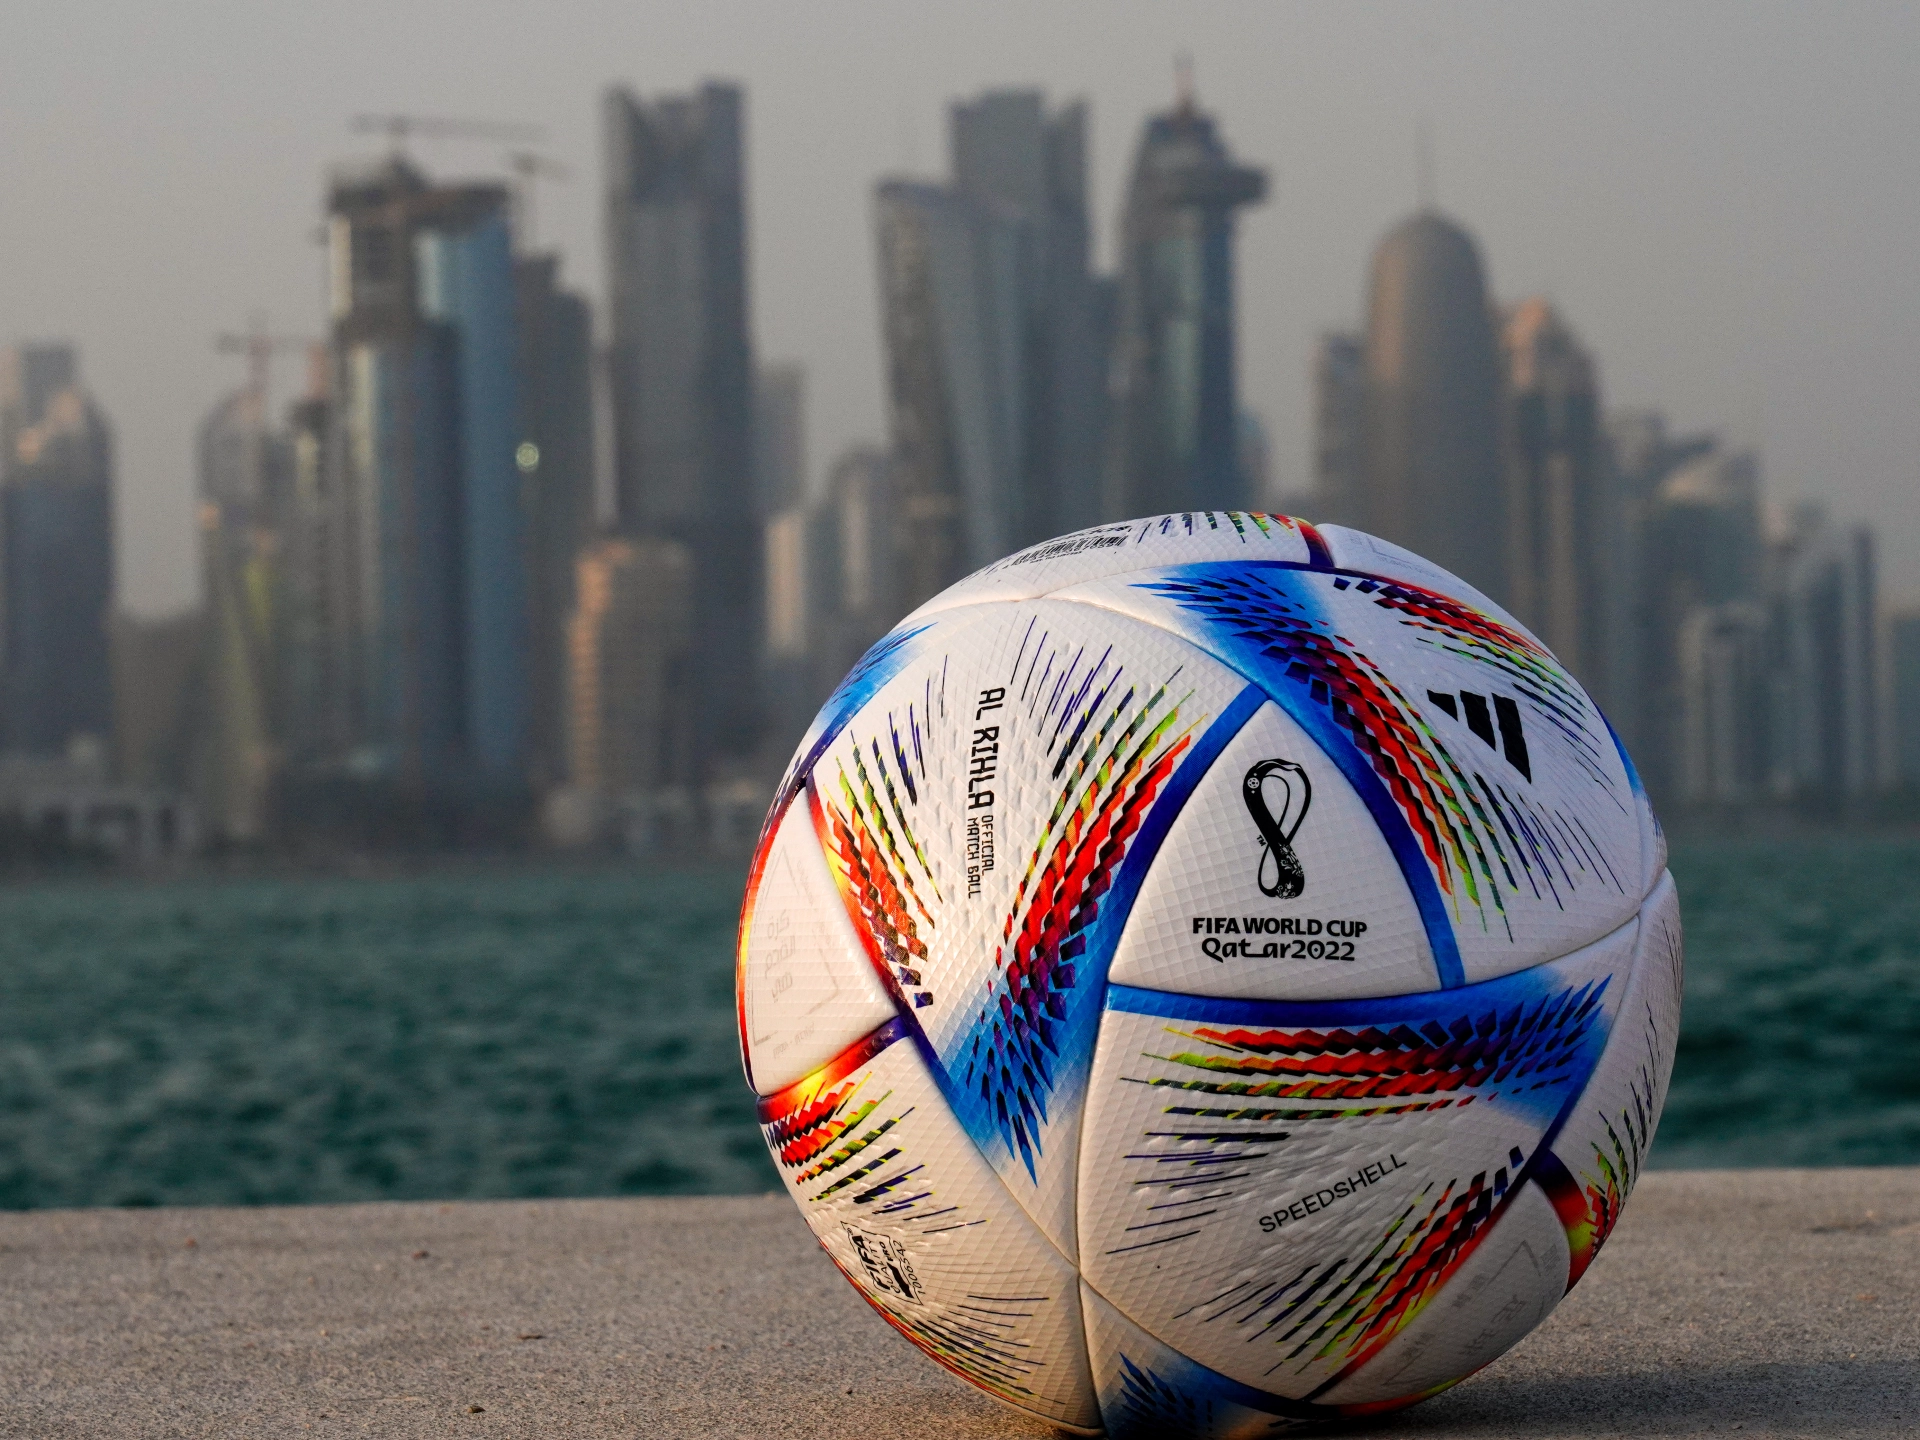

Growing up I played a lot of soccer (or football). There has been a lot of hype around this 2022 World Cup, largely because of  famous internet personalties on TikTok. People are also really rooting for Messi (Argentina) to win his first World Cup this year, as it is his last World Cup. So naturally when I came across this data set, I thought it would be fun to explore and analyze international football matches! Also to see if I could predict the first four 2022 World Cup games only using this data (a combination of international football matches and FIFA stats). This will likely prove to be challenging, some would say even harder than winning the actual World Cup, but with some creative problem solving I believe we can get some decent results! Let's see load in the data and see what we are dealing with ⚽

# Loading Data

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import opendatasets as od
import os

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Downloading the Kaggle FIFA World Cup data
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files("brenda89/fifa-world-cup-2022/download?datasetVersionNumber=12")

# Checking to make sure it downloaded in directory
os.listdir()

['.ipynb_checkpoints',
 'dataset',
 'fifa-world-cup-2022.zip',
 'Fifa_International_2022.ipynb',
 'Fifa_World_Cup_2022.ipynb',
 'Untitled.ipynb',
 'XGB_model.pkl']

In [3]:
# Unzip file
import zipfile
with zipfile.ZipFile("C://Users//fishe//FifaWorldCup2022//fifa-world-cup-2022.zip", 'r') as zip_ref:
    zip_ref.extractall("C://Users//fishe//FifaWorldCup2022//dataset//")

In [4]:
# Read in world data save as df
df = pd.read_csv("C://Users//fishe//FifaWorldCup2022//dataset//international_matches.csv", parse_dates = ['date'])
df.head(5)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,...,No,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-08-08,Guinea,Sierra Leone,Africa,Africa,65,86,0,0,1,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-08-08,Paraguay,Argentina,South America,South America,67,5,0,0,1,...,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Understand our data
print('There are', df.shape[0], 'rows and', df.shape[1], 'columns in our dataframe!')

# Column names and total null values
df.isnull().sum()

There are 23921 rows and 25 columns in our dataframe!


date                                 0
home_team                            0
away_team                            0
home_team_continent                  0
away_team_continent                  0
home_team_fifa_rank                  0
away_team_fifa_rank                  0
home_team_total_fifa_points          0
away_team_total_fifa_points          0
home_team_score                      0
away_team_score                      0
tournament                           0
city                                 0
country                              0
neutral_location                     0
shoot_out                            0
home_team_result                     0
home_team_goalkeeper_score       15542
away_team_goalkeeper_score       15826
home_team_mean_defense_score     16134
home_team_mean_offense_score     15411
home_team_mean_midfield_score    15759
away_team_mean_defense_score     16357
away_team_mean_offense_score     15609
away_team_mean_midfield_score    15942
dtype: int64

In [6]:
# Create home points variable
def label_home_pts (row):
    if row['home_team_result'] == 'Win':
        return 3
    if row['home_team_result'] == 'Draw':
        return 1
    else:
        return 0

df['home_pts'] = df.apply(lambda row: label_home_pts(row), axis=1)

# Create away points variable
def label_away_pts (row):
    if row['home_pts'] == 0:
        return 3
    if row['home_pts'] == 1:
        return 1
    else:
        return 0

df['away_pts'] = df.apply(lambda row: label_away_pts(row), axis=1)

In [7]:
# Drop last home/away position scores as it is missing too much data
df_full = df
df = df.drop(df.iloc[:, 17:-2],axis = 1)

# EDA

In [8]:
# Create new dataframe with away team and home team fifa points appended
rank = df[['date','home_team','away_team','home_team_fifa_rank', 'away_team_fifa_rank',
           'home_team_continent','away_team_continent','home_team_total_fifa_points', 'away_team_total_fifa_points',
           'home_pts', 'away_pts']]

home = rank[['date','home_team','home_team_continent','home_team_fifa_rank','home_team_total_fifa_points', 'home_pts']].rename(
    columns={"home_team":"team","home_team_fifa_rank":"fifa_rank", 
             "home_team_continent":"continent", "home_team_total_fifa_points":"fifa_points", "home_pts": "score_pts"})

away = rank[['date','away_team','away_team_continent','away_team_fifa_rank','away_team_total_fifa_points', "away_pts"]].rename(
    columns={"away_team":"team","away_team_fifa_rank":"fifa_rank", 
             "away_team_continent":"continent", "away_team_total_fifa_points":"fifa_points", "away_pts": "score_pts"})

rank = pd.concat([home,away])

<Figure size 720x720 with 0 Axes>

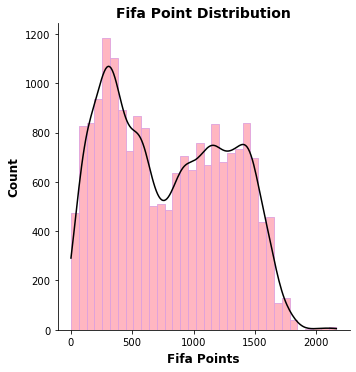

In [9]:
# Plot distribution of fifa_points (excluding 0, as that is by far the most common)
import seaborn as sns
import matplotlib.pyplot as plt

temp_rank = rank.reset_index(drop=True)
temp_rank = temp_rank[temp_rank["fifa_points"]!=0]
temp_rank["fifa_points"] = temp_rank.fifa_points.astype(float)

# Plot frequency of fifa points
plt.figure(figsize=(10,10))
sns.displot(temp_rank, x="fifa_points", facecolor="lightpink", edgecolor="plum", kde=True, color='black')

# Add labels
plt.title('Fifa Point Distribution', fontsize=14, weight="bold")
plt.xlabel('Fifa Points', fontsize=12, weight="bold", labelpad=5)
plt.ylabel('Count', fontsize=12, weight="bold", labelpad=5)

plt.show()

There is a bimodal distribution for FIFA points. Most national teams either have 250 and 1250 FIFA points. We can also see a slight skewness to the right indicating that very few teams have FIFA points above 1600. The Kernel Density Estimation line helps visualize the general bimodal shape of FIFA points for each country.

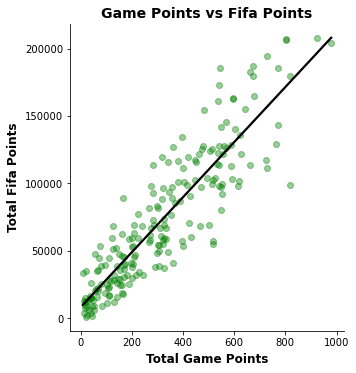

In [10]:
# Find the total number of game points by country
team_pts = rank.groupby('team')[['score_pts','fifa_points']].agg('sum').sort_values('score_pts', ascending=False)

# Look at the relationship between score points to fifa points
sns.lmplot(x = 'score_pts', y = 'fifa_points', data = team_pts, scatter_kws = {'alpha':0.4,'color':'green'},
           line_kws={'color':'black'},ci=None)

# Add labels
plt.title('Game Points vs Fifa Points', fontsize=14, weight="bold")
plt.xlabel('Total Game Points', fontsize=12, labelpad=5, weight="bold")
plt.ylabel('Total Fifa Points', fontsize=12, labelpad=5, weight="bold")

plt.show()

We we can see there is a strong positive linear relationship between the total points a national team earned and their respective FIFA video game points. Going based on a national team's history, it appears that FIFA does a decent job of awording teams with strong historical winning records (or a lot of games), with a large amount of FIFA points. However, their FIFA points model takes more into account than just historical record. A log transformation might help uncover some of the patterns here since the y-axis scale is signifcantly larger than the x-axis, but in general, the graph tells a story we would expect.

In [11]:
# Select each country's latest match
rank = rank.sort_values(['team','date'],ascending=[True,False])
rank = rank.groupby('team').first().sort_values(['fifa_rank', 'fifa_points'],ascending=[True,False]).reset_index()

# Display results for the top 10 countries with the highest fifa video game points 
rank= rank[["team", "continent", "date", "fifa_rank", "fifa_points"]]
rank.head(10)

,team,continent,date,fifa_rank,fifa_points
0,Brazil,South America,2022-06-06,1,1832
1,Belgium,Europe,2022-06-14,2,1827
2,France,Europe,2022-06-13,3,1789
3,Argentina,South America,2022-06-05,4,1765
4,England,Europe,2022-06-14,5,1761
5,Italy,Europe,2022-06-14,6,1723
6,Spain,Europe,2022-06-12,7,1709
7,Portugal,Europe,2022-06-12,8,1674
8,Mexico,North America,2022-06-14,9,1658
9,Netherlands,Europe,2022-06-14,10,1658


In [12]:
# Let's now find the continents with the highest fifa video game points per country
continent = rank.groupby('continent').agg(
    {
         'fifa_points':sum,    # Sum of fifa video game points per continent
         'team': "count",  # get the count of teams per continent
    }
)

continent['fifa_points_per_team'] = continent.fifa_points/continent.team

# Round to nearest integer, and show results
continent = continent.sort_values('fifa_points_per_team', ascending=False)
continent.round({'points_per_team': 0})

,fifa_points,team,fifa_points_per_team
continent,,,
South America,18758,13,1442.923077
Europe,75926,55,1380.472727
Africa,66508,56,1187.642857
Asia,49891,44,1133.886364
North America,35100,32,1096.875000
Oceania,11482,11,1043.818182


From the first table above, we can see that out of the top 10 countries with the highest FIFA points at their most recent match: 7 were from Europe, 2 were from South America, and 1 was from North America. Europe having the most teams in the top 10 is not suprising as they are well known for having top quality national teams, but there are also a lot of countires in Europe. So, it is not copmletely fair to assume that their teams are the best international performers have the most FIFA points on average. 

When looking at the second table, South America has the highest fifa points on average. South America has some of the best teams in the world namely Brazil and Argentina. Having only 13 countries and some of the best preforming nations, they slide in at the number one spot. Europe falls second partly due to the large amount of national teams they have (wide dispersion of talent). Interestingly, North America falls second to last when looking at averages. This is likely because Mexico is really the only national team that preforms well internationally (outside of maybe the Untied States). Thus, the average is likely overwhelming skewed by small nations that do not have the resources to develop into strong international competitors. 

Now let's visualize the continents with their average FIFA points per team with a bar chat!


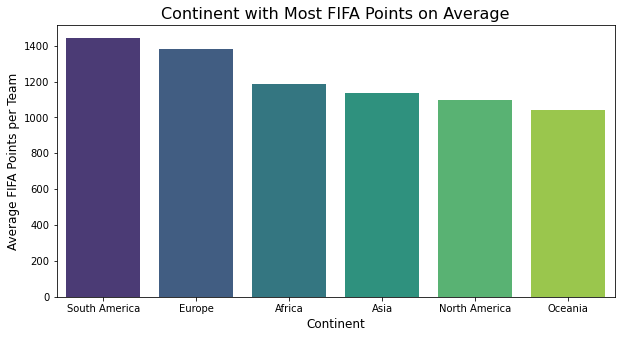

In [13]:
# Plot continent and points per team
plt.figure(figsize=(10,5))
sns.barplot(data=continent, x=continent.index, y="fifa_points_per_team", palette='viridis')

plt.title("Continent with Most FIFA Points on Average", fontsize=16)
plt.xlabel("Continent", fontsize=12)
plt.ylabel("Average FIFA Points per Team", fontsize=12)

plt.show()

In [14]:
# Cleaning dataset to compare tournaments, continent, and total game points

# Make a subset of FIFA World Cup, Friendly, FIFA World Cup qualification
location = ['FIFA World Cup', 'Friendly', 'FIFA World Cup qualification']
country_pts = df[df['tournament'].isin(location)]

# Restructure dataframe to group by team and tournament
country_pts = country_pts[['home_team','away_team','home_pts', 'away_pts', 'tournament']]
home_tour = country_pts.groupby(['home_team','tournament'])['home_pts'].agg(sum).reset_index()
away_tour =  country_pts.groupby(['away_team','tournament'])['away_pts'].agg(sum).reset_index()

# Merge home and away subsets together with continent information, using home team as merge (helps eliminate teams with 1 game)
country_pts = pd.merge(home_tour, away_tour,  how='outer', left_on=['home_team','tournament'], right_on = ['away_team','tournament'])
country_pts = pd.merge(country_pts, df[['home_team', 'home_team_continent']], how='inner', on='home_team')

# Drop duplicates
country_pts = country_pts.drop_duplicates().reset_index(drop=True)
country_pts['total_pts'] = country_pts.home_pts + country_pts.away_pts
country_pts = country_pts.drop(['away_team','home_pts', 'away_pts'], axis=1)

# Rename columns
country_pts = country_pts.rename(columns={"home_team":"team", "home_team_continent": "continent"})

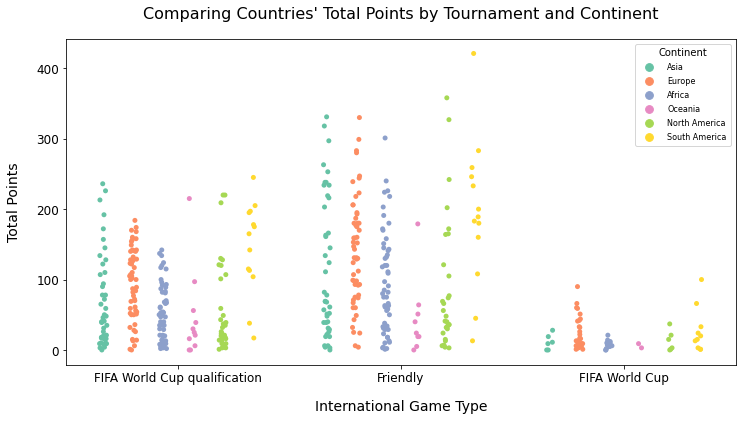

In [15]:
# Countries' total points by tournament and by continent 
plt.figure(figsize=(12,6))
ax = sns.stripplot(x="tournament", y="total_pts", hue="continent",data=country_pts, palette="Set2", dodge=True)

plt.legend(title='Continent')
plt.setp(ax.get_legend().get_texts(), fontsize='8') 
plt.setp(ax.get_legend().get_title(), fontsize='10') 

plt.title("Comparing Countries' Total Points by Tournament and Continent", fontsize=16, pad=20)
plt.xlabel("International Game Type", fontsize=14,labelpad=15)
plt.xticks(fontsize=12)
plt.ylabel("Total Points", fontsize=14, labelpad=15)
plt.yticks(fontsize=12)

plt.show()

Interestingly, all of the continents preform somewhat evenly in the FIFA World Cup qualifiers and friendlies. There is only exception, which is the Oceanic islands. Oceania appears to do worse compared to other continents, but this is likely because the only team that is competitive internationaly is Australia (the upper outlier in the qualifiers and friendlies). I am suprised that Europe does not shine in friendlies or qualifiers though, as they have points that are significantly higher than most continents for World Cup matches. I was also intrigued by how well Asia generally does in inernational competitions. I feel as if they have underappreciated national teams compared to other continents. Lastly, the top outlier for friendlies is Brazil, and due to their strong national team history and current FIFA video game ranking, this makes sense. 

In [16]:
# Find the maximum, and average difference in score for World Cup games
import math
goal_diff = df.home_team_score - df.away_team_score

print('The highest goal difference in a international game is', goal_diff.abs().max())
print ('The average goal difference in a international game is', math.ceil(goal_diff.abs().mean()))

The highest goal difference in a international game is 31
The average goal difference in a international game is 2


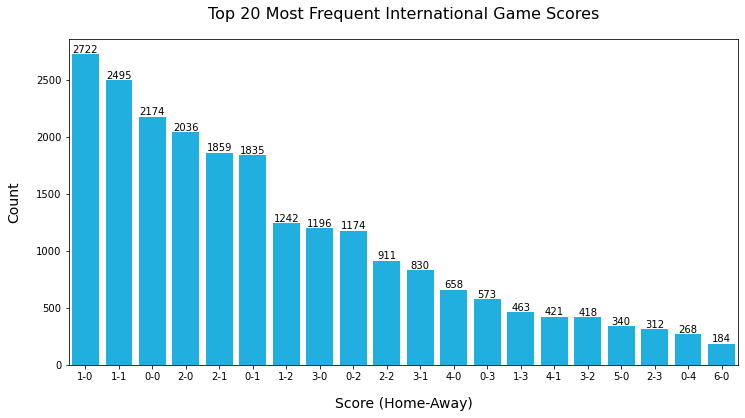

In [17]:
 # Create a fequency table grouped by home team and away team score
freq = df.groupby(["home_team_score", "away_team_score"]).size().reset_index(name="Count")
freq = freq.sort_values('Count', ascending=False)

# New text variable to display a game's scoreline
freq["Score"] = freq.home_team_score.astype(str) + '-' + freq.away_team_score.astype(str)
freq = freq.head(20)

# Plot frequency of the scores and what most common scoreline is 
plt.figure(figsize=(12,6))
ax = sns.barplot(data=freq, x="Score", y="Count", color = 'deepskyblue')
ax.bar_label(ax.containers[0])

plt.title("Top 20 Most Frequent International Game Scores", fontsize=16, pad=20)
plt.xlabel("Score (Home-Away)", fontsize=14,labelpad=15)
plt.ylabel("Count", fontsize=14, labelpad=15)

plt.show()

The top 5 bars all occur when the home team either wins or draws. So this may indicate that a home field advantage could occur in international competitions, despite most games being played on "neutral" ground. Furthermore there is a quick drop off after the 0-2 score, implying that most games are low scoring in football, which is not suprising but it is reassuring that the data backs this up. Football is natorious for being slow paced and low scoring. To me, this is the charm as you can see plays develop out and everyone gets excited over a moment of brilliance. To some, they put a game on to fall asleep.

# World Cup 2022

Now that we understand our data a bit more, we can go on and try to predict who will win the first game based on FIFA stats!

In [18]:
# Select all the World Cup 2022 teams from df
WC2022_Teams = ['Qatar', 'Germany', 'Denmark', 'Brazil', 'France', 'Belgium', 'Croatia', 
                'Spain', 'Serbia', 'England', 'Switzerland', 'Netherlands', 'Argentina', 
                'IR Iran', 'Korea Republic', 'Japan', 'Saudi Arabia', 'Ecuador', 'Uruguay', 
                'Canada', 'Ghana', 'Senegal', 'Portugal', 'Poland', 'Tunisia', 'Morocco', 
                'Cameroon', 'USA', 'Mexico', 'Wales', 'Australia', 'Costa Rica']

df_final = df_full[(df_full["home_team"].apply(lambda x: x in WC2022_Teams)) | (df["away_team"].apply(lambda y: y in WC2022_Teams))].reset_index(drop=True)

# Print out final df
df_final.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score,home_pts,away_pts
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0
3,1993-08-08,Paraguay,Argentina,South America,South America,67,5,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3
4,1993-08-11,Sweden,Switzerland,Europe,Europe,4,3,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3


In [19]:
# If a team does not have a FIFA score, it means that they are not quality enough to be in the dataset, therefore below avg
df_final = df_final.fillna(40)

In [20]:
# Mapping numeric values for home_team_result to find the correleations
df_final['home_team_result'] = df_final['home_team_result'].map({'Win':1, 'Draw':2, 'Lose':0})

In [21]:
# Drop redundant/not usable columns
df_final = df_final.drop(['home_team_continent','away_team_continent','home_team_total_fifa_points', 
                          'away_team_total_fifa_points','home_team_score', 'away_team_score', 'tournament', 'city', 
                          'country','neutral_location', 'shoot_out'],axis=1)

In [22]:
# Create away scpre variable
def label_away_score (row):
    if row['away_pts'] == 0:
        return 0
    if row['away_pts'] == 1:
        return 1
    else:
        return 2

df_final['away_team_result'] = df_final.apply(lambda row: label_away_score(row), axis=1)

In [23]:
# Re structure data
TeamA = df_final[['date','home_team','away_team','home_team_fifa_rank','away_team_fifa_rank','home_pts', 'away_pts',
                  'home_team_result', 'home_team_goalkeeper_score','home_team_mean_defense_score', 'home_team_mean_offense_score', 
                 'home_team_mean_midfield_score']].rename(
    columns={"home_team":"TeamA", "away_team":"TeamB","home_team_fifa_rank":"TeamA_fifa_rank", 
             "away_team_fifa_rank":"TeamB_fifa_rank", "home_pts": "TeamA_pts", "away_pts": "TeamB_pts", "home_team_result": "TeamA_result",
             "home_team_goalkeeper_score":"TeamA_gk_score","home_team_mean_defense_score":"TeamA_def_score", 
             "home_team_mean_offense_score":"TeamA_off_score", "home_team_mean_midfield_score":"TeamA_mid_score"})
TeamA['home'] = 1

TeamB = df_final[['date','away_team','home_team','away_team_fifa_rank','home_team_fifa_rank','away_pts', 'home_pts',
                  'away_team_result', 'away_team_goalkeeper_score','away_team_mean_defense_score', 'away_team_mean_offense_score', 
                 'away_team_mean_midfield_score']].rename(
    columns={"away_team":"TeamA", "home_team":"TeamB", "away_team_fifa_rank":"TeamA_fifa_rank", 
             "home_team_fifa_rank":"TeamB_fifa_rank", "away_pts": "TeamA_pts", "home_pts": "TeamB_pts", "away_team_result": "TeamA_result",
             "away_team_goalkeeper_score":"TeamA_gk_score","away_team_mean_defense_score":"TeamA_def_score", 
             "away_team_mean_offense_score":"TeamA_off_score", "away_team_mean_midfield_score":"TeamA_mid_score"})
TeamB['home'] = 0

df_final = pd.concat([TeamA,TeamB]).sort_index(kind='merge')
df_final.reset_index(drop=True, inplace=True)
df_final.head()

,date,TeamA,TeamB,TeamA_fifa_rank,TeamB_fifa_rank,TeamA_pts,TeamB_pts,TeamA_result,TeamA_gk_score,TeamA_def_score,TeamA_off_score,TeamA_mid_score,home
0,1993-08-08,Bolivia,Uruguay,59,22,3,0,1,40.0,40.0,40.0,40.0,1
1,1993-08-08,Uruguay,Bolivia,22,59,0,3,0,40.0,40.0,40.0,40.0,0
2,1993-08-08,Brazil,Mexico,8,14,1,1,2,40.0,40.0,40.0,40.0,1
3,1993-08-08,Mexico,Brazil,14,8,1,1,1,40.0,40.0,40.0,40.0,0
4,1993-08-08,Ecuador,Venezuela,35,94,3,0,1,40.0,40.0,40.0,40.0,1


In [24]:
# Shift points up (create a lag)
df_final['prev_valueA'] = df_final.groupby('TeamA')['TeamA_pts'].shift()
df_final['prev_valueB'] = df_final.groupby('TeamA')['TeamB_pts'].shift()

# Create new variable for pts rolling average per country
df_final['TeamA_MA_pts'] = df_final.groupby('TeamA')['prev_valueA'].transform(lambda x: x.rolling(5, 1).mean())
df_final['TeamB_MA_pts'] = df_final.groupby('TeamB')['prev_valueB'].transform(lambda x: x.rolling(5, 1).mean())

In [25]:
# drop TeamA points and dates as they are not needed for predictions
df_final = df_final.drop(['date','TeamA_pts','TeamB_pts', 'prev_valueA','prev_valueB'], axis=1)

# MA results in null, and sometimes they are smaller teams. Deleting duplicate rows doesn't ensure 50/ 50 prediction. Stratify will help
# drop NaNs
df_final = df_final.dropna().reset_index(drop=True)

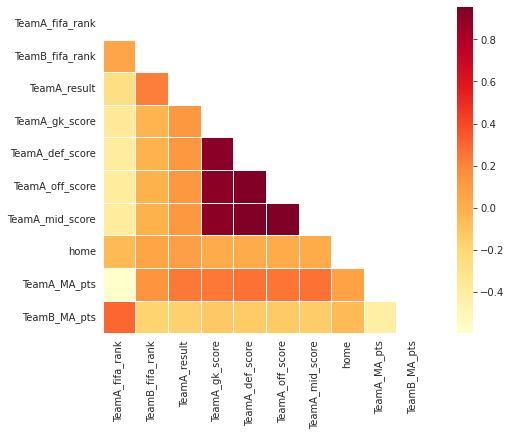

In [26]:
# Trinagle Heat map of each numeric variable correlated with each other
corr = df_final.corr()                                       #Correlation of variables
mask = np.zeros_like(corr)                             #Forcing variables to have a correlation of 0
mask[np.triu_indices_from(mask)] = True                #Upper right triangle portion to have correlation of 0 (mask these cells)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(corr,mask=mask,square=True,linewidths=.8,cmap="YlOrRd")

A team's goal keeper, offense, defense, and midfield are all highly correlated with each other. Also a team's rank is negatively correlated with their team's fifa stats, which makes sense. Futhermore, the new variable we created Team_MA_pts. which takes the rolling average up until the last 5 games, is moderately correlated with TeamA results! Outside of FIFA rank, it may be the strongest predictor of a team's result.

# Modeling

Now that we have finsihed cleaning, exploring, and understanding the data we can start to predict World Cup 2022 games!

In [27]:
# Need to drop teams you have not played many games
removeA = df_final.groupby('TeamA')['TeamA'].count()
removeA = removeA[removeA<5]
remove_listA = removeA.index.to_list()

removeB = df_final.groupby('TeamB')['TeamB'].count()
removeB = removeB[removeB<5]
remove_listB = removeB.index.to_list()

# If countries are in remove list, drop those rows/games as they might cause unnecessary problems in test/train split
df_final = df_final.drop(df_final[
    (df_final['TeamA'].apply(lambda x: x in remove_listA)) | (df_final['TeamB'].apply(lambda x: x in remove_listB))
].index).reset_index(drop=True)


In [28]:
# Import necessary packages
import pickle

# Create pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

# Import confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Scaling and Encoding
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import LeaveOneOutEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [29]:
# World cup games after group stages cannot draw
df_final = df_final[df_final['TeamA_result']!=2]

In [30]:
# Define features and target
X = df_final.drop('TeamA_result', axis=1)
y = df_final['TeamA_result']

In [31]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
# Fill out column datatypes
num_cols = ["TeamA_fifa_rank", "TeamB_fifa_rank", "TeamA_gk_score", "TeamA_def_score", "TeamA_off_score", "TeamA_mid_score", 
           "TeamA_MA_pts", "TeamB_MA_pts"]

bin_cols = ["home"]

cat_cols = ["TeamA", "TeamB"]
drop_cats = ["Algeria", "Ecuador"]

In [33]:
# Hot Ecnode cat cols and scale num cols
preprocessing = ColumnTransformer([
    # Encode categories
    ("LeaveOneOutEncoder", LeaveOneOutEncoder(), cat_cols),

    # Scale numeric columns 
    ("scaler", StandardScaler(), num_cols)
], remainder="passthrough")

In [34]:
# Create pipeline for Logistic model
pipeline = Pipeline([
    # Apply ColumnTransformer steps
    ("preprocessing", preprocessing),

    # put model in here
    ("modelLOG", LogisticRegression(max_iter=1000 ))
    #("modelSVC", SVC()),
    #("modelRFC", RandomForestClassifier()),
    #("modelADA", AdaBoostClassifier()),
    #("modelXGB", XGBClassifier())
])

In [35]:
# Create grid search for Logisitc model
grid = {
    "modelLOG__C": [1,10],
}

pipeline_cv = GridSearchCV(pipeline, grid)
pipeline_cv.fit(X_train, y_train);

              precision    recall  f1-score   support

           0       0.73      0.76      0.75      1404
           1       0.73      0.69      0.71      1310

    accuracy                           0.73      2714
   macro avg       0.73      0.73      0.73      2714
weighted avg       0.73      0.73      0.73      2714



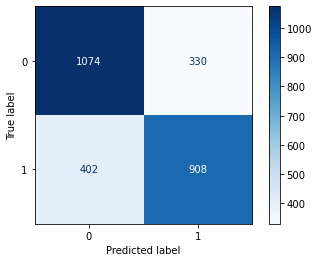

In [36]:
# Testing model Logistic Regression
best_model = pipeline_cv.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test,y_pred))
disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred, cmap=plt.cm.Blues)

In [37]:
# Create pipeline for SVC model
pipeline = Pipeline([
    # Apply ColumnTransformer steps
    ("preprocessing", preprocessing),

    # put model in here
    #("modelLOG", LogisticRegression(max_iter=1000 ))
    ("modelSVC", SVC()),
    #("modelRFC", RandomForestClassifier()),
    #("modelADA", AdaBoostClassifier()),
    #("modelXGB", XGBClassifier())
])

In [38]:
# Create grid search for SVC model
grid = {
    "modelSVC__C": [1,10],
    "modelSVC__gamma":[1,0.1], 
    "modelSVC__kernel":['linear','rbf'],
}

pipeline_cv = GridSearchCV(pipeline, grid)
pipeline_cv.fit(X_train, y_train);

              precision    recall  f1-score   support

           0       0.72      0.77      0.75      1404
           1       0.74      0.68      0.71      1310

    accuracy                           0.73      2714
   macro avg       0.73      0.73      0.73      2714
weighted avg       0.73      0.73      0.73      2714



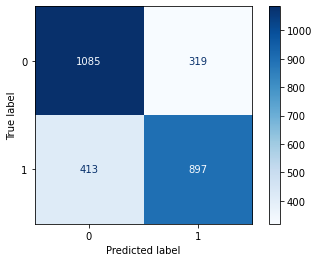

In [39]:
# Testing model SVC
best_model = pipeline_cv.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test,y_pred))
disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred, cmap=plt.cm.Blues)

In [40]:
# Create pipeline for RFC model
pipeline = Pipeline([
    # Apply ColumnTransformer steps
    ("preprocessing", preprocessing),

    # put model in here
    #("model", SVC()),
    ("modelRFC", RandomForestClassifier()),
    #("modelADA", AdaBoostClassifier()),
    #("modelXGB", XGBClassifier())
])

In [41]:
# Create grid search for RFC model
grid = {
    "modelRFC__n_estimators": [400, 500, 600],
    "modelRFC__max_depth": [40, 50, 60],
    "modelRFC__min_samples_leaf": [3, 5, 8]
}

pipeline_cv = GridSearchCV(pipeline, grid)
pipeline_cv.fit(X_train, y_train);

              precision    recall  f1-score   support

           0       0.70      0.76      0.73      1404
           1       0.72      0.65      0.68      1310

    accuracy                           0.71      2714
   macro avg       0.71      0.71      0.71      2714
weighted avg       0.71      0.71      0.71      2714



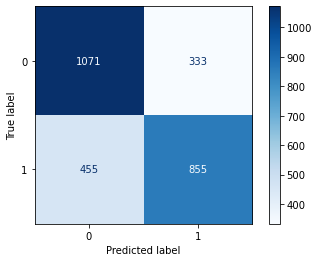

In [42]:
# Testing model Random Forest Classifier
best_model = pipeline_cv.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test,y_pred))
disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred, cmap=plt.cm.Blues)

In [43]:
# Create pipeline for ADA model
pipeline = Pipeline([
    # Apply ColumnTransformer steps
    ("preprocessing", preprocessing),

    # put model in here
    #("model", SVC()),
    #("modelRFC", RandomForestClassifier()),
    ("modelADA", AdaBoostClassifier()),
    #("modelXGB", XGBClassifier())
])

In [44]:
# Create grid search for ADA model
grid = {
    "modelADA__n_estimators": [10, 100, 400],
    "modelADA__learning_rate": [(0.97 + x / 100) for x in range(0, 4)],
    "modelADA__algorithm": ['SAMME', 'SAMME.R']
}

pipeline_cv = GridSearchCV(pipeline, grid)
pipeline_cv.fit(X_train, y_train);

              precision    recall  f1-score   support

           0       0.73      0.67      0.70      1404
           1       0.68      0.73      0.70      1310

    accuracy                           0.70      2714
   macro avg       0.70      0.70      0.70      2714
weighted avg       0.70      0.70      0.70      2714



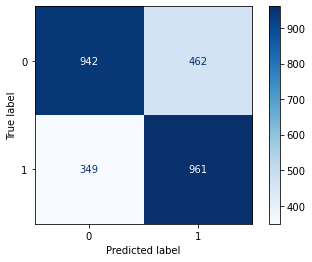

In [45]:
# Testing model ADABoost
best_model = pipeline_cv.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test,y_pred))
disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred, cmap=plt.cm.Blues)

In [58]:
# Create pipeline for XGB model
pipeline = Pipeline([
    # Apply ColumnTransformer steps
    ("preprocessing", preprocessing),

    # put model in here
    #("model", SVC()),
    #("modelRFC", RandomForestClassifier()),
    #("modelADA", AdaBoostClassifier()),
    ("modelXGB", XGBClassifier(objective='binary:logistic',
                              use_label_encoder=False, 
                              eval_metric='rmse'))
])

In [59]:
# Create grid search for XGB model
grid = {
    'modelXGB__colsample_bytree': [.4, .8, 1.2],
    'modelXGB__learning_rate': [(0.97 + x / 100) for x in range(0, 4)],
    'modelXGB__n_estimators': [10, 100, 400], 
    'modelXGB__reg_alpha': [1,10,100],
    'modelXGB__reg_lambda': [1,10,100],
    'modelXGB__gamma': [1,10,100],
    'modelXGB__max_depth': [5,10,15],
    
    
}

pipeline_cv = GridSearchCV(pipeline, grid)
pipeline_cv.fit(X_train, y_train);

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      1404
           1       0.75      0.66      0.70      1310

    accuracy                           0.73      2714
   macro avg       0.73      0.73      0.73      2714
weighted avg       0.73      0.73      0.73      2714



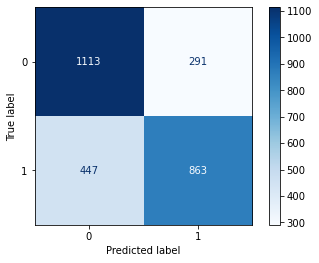

In [48]:
# Testing model XGB
best_model = pipeline_cv.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test,y_pred))
disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred, cmap=plt.cm.Blues)

In [49]:
# Check results 
results = X_test
results['actual'] = y_test
results['pred'] = y_pred
results[['probL', 'probW']] = best_model.predict_proba(X_test)

# Select only incorrect predictions
check = results[results['actual']!=results['pred']]

# Only look at extremely confident and wrong predictions
check = check[(check['probL']>=.85) | (check['probW']>=.85)]

# See if we can visually parse out similarities based on errors
check.style.background_gradient(axis=1)

,TeamA,TeamB,TeamA_fifa_rank,TeamB_fifa_rank,TeamA_gk_score,TeamA_def_score,TeamA_off_score,TeamA_mid_score,home,TeamA_MA_pts,TeamB_MA_pts,actual,pred,probL,probW
16256,Trinidad and Tobago,Japan,93,26,58.000000,40.000000,40.000000,71.000000,0,0.600000,1.200000,1,0,0.866254,0.133746
16194,Panama,Brazil,76,3,40.000000,69.800000,67.300000,69.500000,0,0.200000,2.000000,1,0,0.874750,0.125250
10438,France,China PR,9,84,86.000000,84.000000,83.300000,84.500000,1,1.600000,1.000000,0,1,0.106526,0.893474
2447,IR Iran,Nigeria,46,71,40.000000,40.000000,40.000000,40.000000,1,0.600000,1.200000,0,1,0.126556,0.873444
5587,Denmark,Bosnia and Herzegovina,11,88,40.000000,40.000000,40.000000,40.000000,1,2.600000,0.200000,0,1,0.117612,0.882388
10347,Iceland,Mexico,91,15,71.000000,72.200000,73.000000,69.000000,0,0.000000,2.400000,1,0,0.879265,0.120735
7366,North Macedonia,Netherlands,96,2,71.000000,66.800000,64.300000,64.200000,0,0.200000,2.000000,1,0,0.865823,0.134177
6635,Qatar,Syria,62,87,40.000000,40.000000,40.000000,40.000000,1,1.400000,0.600000,0,1,0.145626,0.854374
18255,IR Iran,Algeria,21,44,73.000000,69.000000,75.300000,69.000000,1,2.400000,0.600000,0,1,0.137781,0.862219
1749,USA,Peru,18,54,40.000000,40.000000,40.000000,40.000000,1,2.000000,1.600000,0,1,0.148720,0.851280


In [50]:
# Most are upsets let's check average rank difference for these games.
np.mean(abs(check['TeamA_fifa_rank'] - check['TeamB_fifa_rank']))

56.891304347826086

Most of these games that the machine predicted wrong were upsets, where the team that was ranked lower won the match. It appears that these games were usually large upsets too, as the average rank difference was 57. We could use clustering to identify variables that were influential in making these predictions, or in this case look at feature importance. However, that may not be necessary. Creating more accurate predictions with this dataset would be difficult. More data would likely need to be collected to make more accurate models. For example, a player report and lineup for each match would probably add more certiany. Perhaps individual top player stats for each team could be useful, etc. There is a lot this is missing here that could chip away at the ommitted variable bias here, but unfortunately we would not have easy access to all of that information. In other words, I do not blame the machine for predicting Germany to beat Nothern Ireland. 

# Prediction

In [51]:
# Pickle the XGB model
with open("XGB_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [52]:
# Load from file
with open("XGB_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [53]:
# Construct new data for the first 4 group games in WC2022
data = {'TeamA': ['Qatar', 'England',  'Senegal', 'USA'],
           'TeamB': ['Ecuador', 'Iran', 'Netherlands', 'Wales'],
           'TeamA_fifa_rank': [52, 5, 20, 15],
           'TeamB_fifa_rank': [46, 21, 10, 18],
           'TeamA_gk_score': [40, 83, 83, 77],
           'TeamA_def_score': [40, 85, 79, 75.8],
           'TeamA_off_score': [40, 88, 80.7, 77.7],
           'TeamA_mid_score': [40, 84, 79, 75.8],
           'home': [1,1,1,1],
           'TeamA_MA_pts': [2.4, 1.6, 2.4, 2],
           'TeamB_MA_pts': [1.2, 2.4, 2.2, 1]}

new_data = pd.DataFrame(data)

# Predict first 4 group games, assuming no draws
y_new_pred = loaded_model.predict(new_data)

In [54]:
# Save predictions to df
new_data['pred'] = y_new_pred

# Retrun the predicted winners
def winner (row):
    if row['pred'] == 1:
        return row['TeamA']
    else:
        return row['TeamB']

new_data['Predicted Winner'] = new_data.apply(lambda row: winner(row), axis=1)

# Looking at the probability that each team wins
new_data[['Likelihood of L (Team A %)', 'Likelihood of W (Team A %)']] = loaded_model.predict_proba(new_data)*100

# Print out prediction table
new_data[['TeamA', 'TeamB', 'Predicted Winner', 'Likelihood of L (Team A %)', 'Likelihood of W (Team A %)']]

,TeamA,TeamB,Predicted Winner,Likelihood of L (Team A %),Likelihood of W (Team A %)
0,Qatar,Ecuador,Qatar,29.879755,70.120247
1,England,Iran,England,17.169231,82.830772
2,Senegal,Netherlands,Netherlands,64.325951,35.674049
3,USA,Wales,USA,23.315668,76.684334


The XGB Boost Model predicts that Qatar, England, Netherlands, and USA will be the first 4 wins in the 2022 World Cup! Furthermore, when looking at the winning percentages, the model appears to be pretty confident that each team will be the winner, except for maybe Netherlands versus Senegal.  

# Summary

We learned that the FIFA football game tends to rank South America and Europe teams higher. We also found out that all continents preformed similarily preform similarily, except in the World Cup games where South America and Europe teams tend to preform better. This does make sense though, as most of the top national teams have historically been from South America and Europe. As for creating a model to predict a winner of an international football match, we found that XGB Boost and Support Vector Classifiers preformed best. I could have chosen either model, but after looking at the XGB errors, I felt most comfortable with its selection, as most of its widely missed errors (strongly confident, but wrong) were upsets that most people would not have expected to happen. So, I used this hypertuned XGB model to predict the first four games of the 2022 World Cup, and as shown above, it favors most of the favored teams except for maybe Qatar. I did specify that Qatar was technically at home, so it may have picked up on some home advantage. Either way, it will be fun to check to see if my predictions are right!⚽